In [238]:
from google.colab import drive
drive.mount("gdrive")

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


##Importing the necessary libraries.

In [239]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier,ExtraTreeRegressor
from sklearn.linear_model import Ridge,Lasso,ElasticNet,RidgeCV,LassoCV,ElasticNetCV
import tensorflow as tf

## Read the dataset.

In [240]:
df = pd.read_csv("/content/gdrive/My Drive/DataAnalysis/Parkinson/parkinsons_updrs.data")

In [241]:
df.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


##Metadata regarding on the dataset.

In [242]:
df.describe()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
count,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000
mean,21.494128,64.804936,0.317787,92.863722,21.296229,29.018942,0.006154,0.000044,0.002987,0.003277,0.008962,0.034035,0.310960,0.017156,0.020144,0.027481,0.051467,0.032120,21.679495,0.541473,0.653240,0.219589
std,12.372279,8.821524,0.465656,53.445602,8.129282,10.700283,0.005624,0.000036,0.003124,0.003732,0.009371,0.025835,0.230254,0.013237,0.016664,0.019986,0.039711,0.059692,4.291096,0.100986,0.070902,0.091498
min,1.000000,36.000000,0.000000,-4.262500,5.037700,7.000000,0.000830,0.000002,0.000330,0.000430,0.000980,0.003060,0.026000,0.001610,0.001940,0.002490,0.004840,0.000286,1.659000,0.151020,0.514040,0.021983
25%,10.000000,58.000000,0.000000,46.847500,15.000000,21.371000,0.003580,0.000022,0.001580,0.001820,0.004730,0.019120,0.175000,0.009280,0.010790,0.015665,0.027830,0.010955,19.406000,0.469785,0.596180,0.156340
50%,22.000000,65.000000,0.000000,91.523000,20.871000,27.576000,0.004900,0.000035,0.002250,0.002490,0.006750,0.027510,0.253000,0.013700,0.015940,0.022710,0.041110,0.018448,21.920000,0.542250,0.643600,0.205500
75%,33.000000,72.000000,1.000000,138.445000,27.596500,36.399000,0.006800,0.000053,0.003290,0.003460,0.009870,0.039750,0.365000,0.020575,0.023755,0.032715,0.061735,0.031463,24.444000,0.614045,0.711335,0.264490
max,42.000000,85.000000,1.000000,215.490000,39.511000,54.992000,0.099990,0.000446,0.057540,0.069560,0.172630,0.268630,2.107000,0.162670,0.167020,0.275460,0.488020,0.748260,37.875000,0.966080,0.865600,0.731730


In [243]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subject#       5875 non-null   int64  
 1   age            5875 non-null   int64  
 2   sex            5875 non-null   int64  
 3   test_time      5875 non-null   float64
 4   motor_UPDRS    5875 non-null   float64
 5   total_UPDRS    5875 non-null   float64
 6   Jitter(%)      5875 non-null   float64
 7   Jitter(Abs)    5875 non-null   float64
 8   Jitter:RAP     5875 non-null   float64
 9   Jitter:PPQ5    5875 non-null   float64
 10  Jitter:DDP     5875 non-null   float64
 11  Shimmer        5875 non-null   float64
 12  Shimmer(dB)    5875 non-null   float64
 13  Shimmer:APQ3   5875 non-null   float64
 14  Shimmer:APQ5   5875 non-null   float64
 15  Shimmer:APQ11  5875 non-null   float64
 16  Shimmer:DDA    5875 non-null   float64
 17  NHR            5875 non-null   float64
 18  HNR     

In [244]:
df.isnull().sum()

subject#         0
age              0
sex              0
test_time        0
motor_UPDRS      0
total_UPDRS      0
Jitter(%)        0
Jitter(Abs)      0
Jitter:RAP       0
Jitter:PPQ5      0
Jitter:DDP       0
Shimmer          0
Shimmer(dB)      0
Shimmer:APQ3     0
Shimmer:APQ5     0
Shimmer:APQ11    0
Shimmer:DDA      0
NHR              0
HNR              0
RPDE             0
DFA              0
PPE              0
dtype: int64

There is no null instance in the dataset which is a very good thing since we can continue on the EDA.

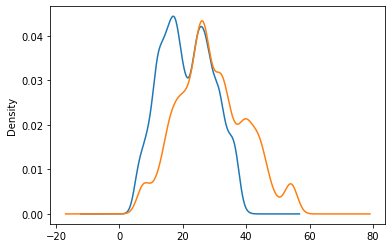

In [245]:
fig, ax = plt.subplots(1,1)
df["motor_UPDRS"].plot(kind="density")
df["total_UPDRS"].plot(kind="density")
fig.show()

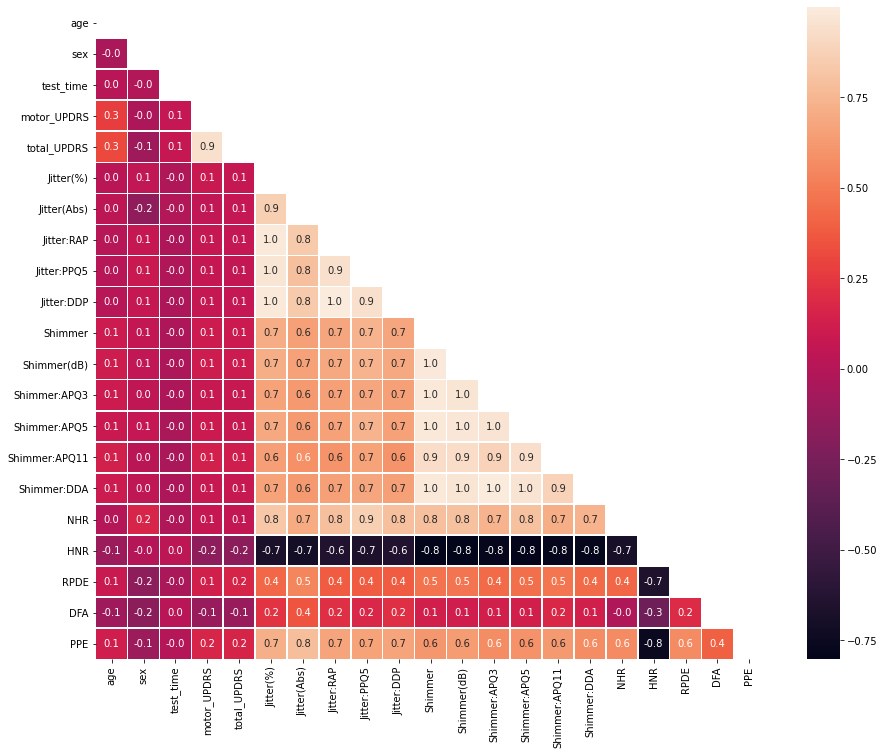

In [246]:
fig, ax = plt.subplots(figsize=(15,12))         # Sample figsize in inches
sns.heatmap(df.drop(columns=["subject#"]).corr(), annot=True, linewidths=.5,ax=ax, fmt= '.1f',mask= np.triu(np.ones_like(df.drop(columns=["subject#"]).corr(), dtype=np.bool)))

Gender is a parameter on the voices of the individuals,we will analyze them separately.

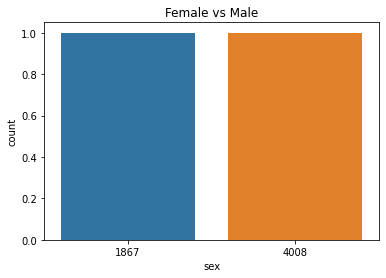

In [247]:
sns.countplot(df.sex.value_counts())
plt.title("Female vs Male")
plt.show()

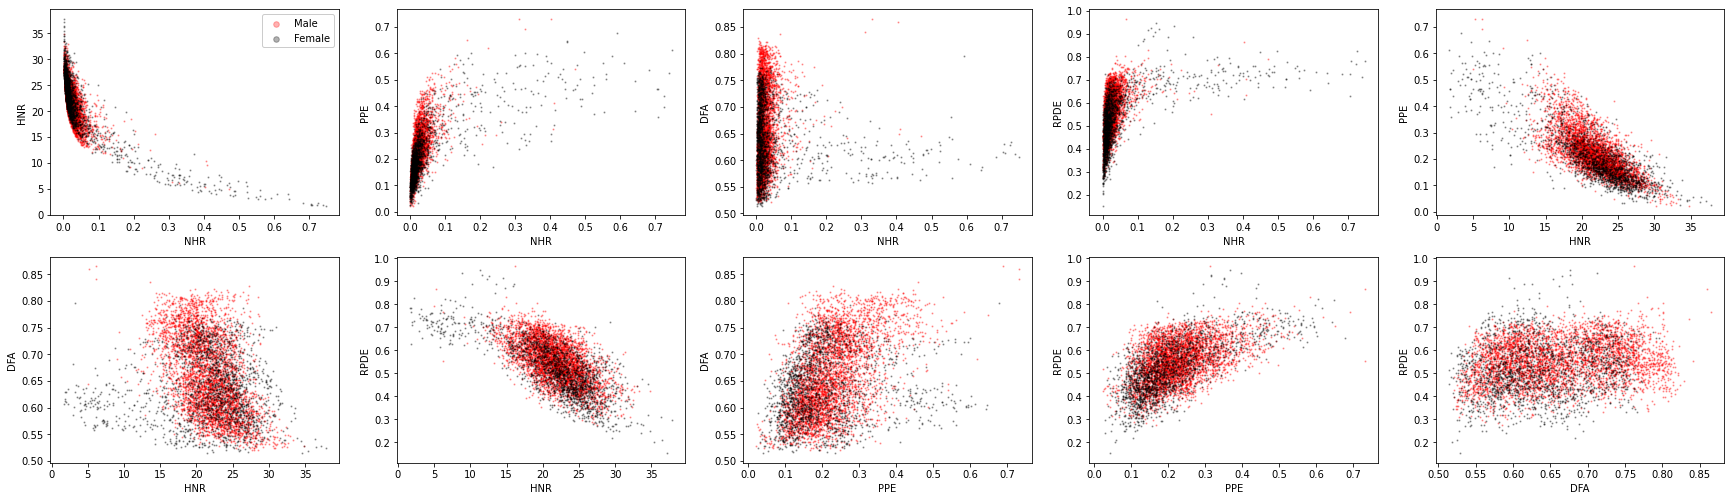

In [248]:
from itertools import combinations
def scatter_patient(df, subject_list, columns, patient_filter, scatter_alpha=0.3):
    fig, ax = plt.subplots(figsize=(30,22))
    f = [comb for comb in combinations(range(len(columns)), 2)]
    
    for _, fp, _ in patient_filter:
        fp = fp & subject_list
        
    for i in range(len(f)):
        plt.subplot(5,5,i + 1)
        column_1 = columns[f[i][0]]
        column_2 = columns[f[i][1]]
        
        for name, fp, color in patient_filter:
            plt.scatter(df[fp][column_1], df[fp][column_2], alpha=scatter_alpha, marker='.', color=color, s=5, label=name)
        
        plt.xlabel(column_1)
        plt.ylabel(column_2)
        if(i == 0 or i == len(f)):
            plt.legend(markerscale=5, framealpha=1)


sex_filter_patient = [('Male', df['sex'] == 0, 'red'), 
                      ('Female', df['sex'] == 1, 'black')]
scatter_patient(df, df['subject#'] == df['subject#'], ['NHR', 'HNR', 'PPE', 'DFA', 'RPDE'], sex_filter_patient)

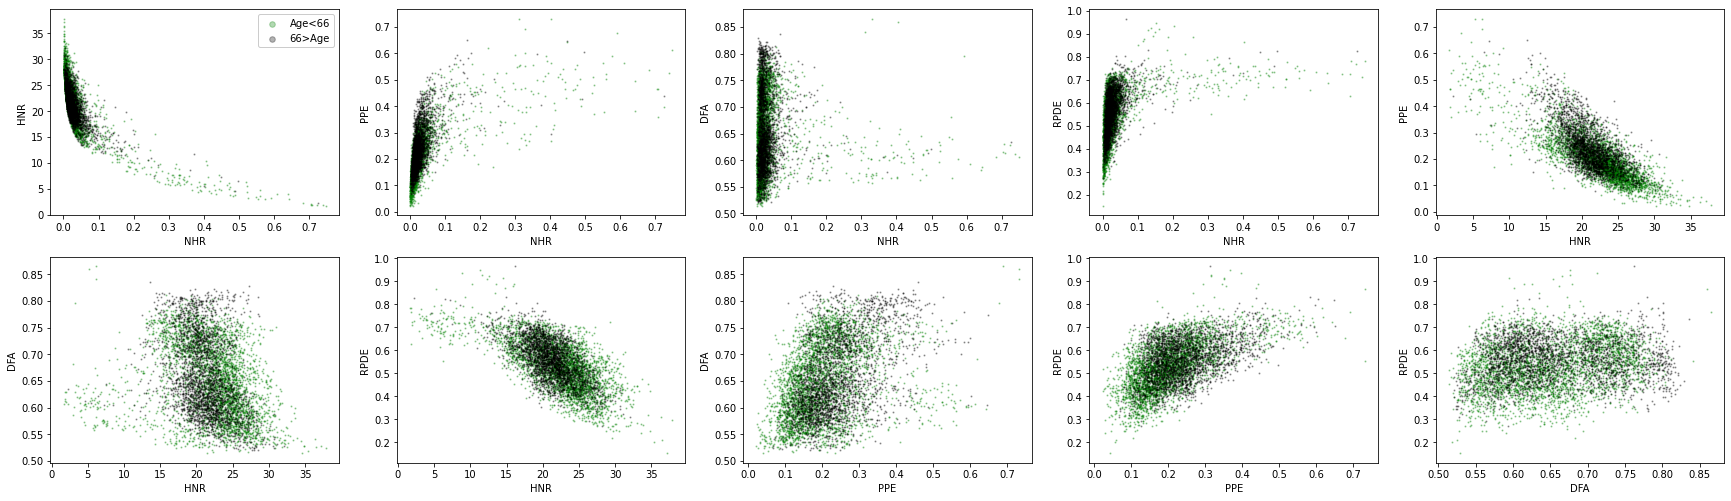

In [249]:
low_margin = 66
less = df['age'] <= low_margin
more = df['age'] > low_margin

age_filter_patient = [('Age<{}'.format(low_margin), less, 'green'), 
                      ('{}>Age'.format(low_margin), more, 'black')]
scatter_patient(df, True, ['NHR', 'HNR', 'PPE', 'DFA', 'RPDE'], age_filter_patient, scatter_alpha=0.3)

## Preprocessing

In [250]:
scaler = StandardScaler()
non_cat = df.drop(columns=["sex"])
cat = df[["sex"]]
non_cat = pd.DataFrame(scaler.fit_transform(non_cat),columns=non_cat.columns)
non_cat["sex"] = cat

In [251]:
features = non_cat.drop(columns=["subject#","motor_UPDRS","total_UPDRS"])
target = df[["motor_UPDRS","total_UPDRS"]]
X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.50,random_state=42)

##Model Selection

In [252]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)
r2_score(y_test,rfr.predict(X_test))

0.9599395201725827

In [253]:
mean_squared_error(y_test,rfr.predict(X_test))

3.5404732116398097

In [254]:
X_train.columns.shape
forest.feature_importances_.shape

(19,)

Feature ranking:
1. feature 0 (0.583464)
2. feature 18 (0.187564)
3. feature 1 (0.073340)
4. feature 16 (0.048062)
5. feature 3 (0.043489)
6. feature 7 (0.015758)
7. feature 14 (0.012459)
8. feature 15 (0.011754)
9. feature 9 (0.004129)
10. feature 17 (0.003976)
11. feature 13 (0.003511)
12. feature 8 (0.002357)
13. feature 12 (0.002248)
14. feature 2 (0.002238)
15. feature 4 (0.001788)
16. feature 10 (0.001725)
17. feature 6 (0.001027)
18. feature 11 (0.000781)
19. feature 5 (0.000330)


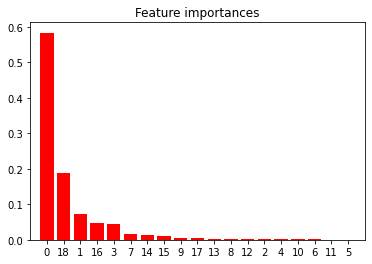

In [255]:
forest = ExtraTreeRegressor()
forest.fit(X_train,y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r",  align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [256]:
X_train.drop(X_train.columns[indices[-12:]],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [257]:
X_train.head()

,age,test_time,Jitter(Abs),Shimmer,HNR,DFA,sex
5653,0.362220,-0.287695,3.451136,2.515964,-1.773240,0.822054,1
4407,0.135483,0.140459,-0.052727,1.005103,-1.716606,-1.209514,1
2696,0.248852,-1.123644,-0.348444,-0.755052,1.253983,2.124385,0
2591,-1.111573,-0.601293,0.964497,-0.410530,-0.081454,1.254378,0
4971,-0.317992,-0.665906,0.166004,2.576352,-2.320466,-1.362837,1


In [258]:
X_test.drop(X_test.columns[indices[-12:]],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [259]:
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [263]:
r2_score(y_test,rfr.predict(X_test))

0.9724228605243563